In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# from google.colab import drive
# # drive.mount('/content/drive')
# drive.mount("/content/drive", force_remount=True)

In [3]:
# data = pd.read_csv('drive/MyDrive/Code/derived_data_csv/new_features_added_filled_nearest_neigb_min.csv')
data = pd.read_csv('./../derived_data_csv/new_features_added_filled_nearest_neigb_min.csv')


In [4]:
data.columns

Index(['city_id', 'date', 'avg_temp_c', 'min_temp_c', 'max_temp_c',
       'avg_wind_dir_deg', 'avg_wind_speed_kmh', 'city', 'day_of_week',
       'day_of_year', 'month', 'temp_range'],
      dtype='object')

In [5]:
# Python
selected_columns_to_exclude = ['date', 'city_id',
                               'snow_depth_mm', 'day_of_week']
features = [col for col in data.columns if col not in selected_columns_to_exclude]

target = 'avg_temp_c'

# Scaling features
scaler = StandardScaler()
# Python
numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

In [6]:
num_rows_with_nulls = data.isnull().any(axis=1).sum()
print(f"Number of records: {len(data)}")
print(f"Number of records with at least one null value: {num_rows_with_nulls}")

Number of records: 182338
Number of records with at least one null value: 0


In [7]:
# print(data[features].head())

# data_filled = data.fillna(-1)
data.head()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,avg_wind_dir_deg,avg_wind_speed_kmh,city,day_of_week,day_of_year,month,temp_range
0,C001,2014-01-01,-1.244652,-1.615164,-1.181246,-0.084152,-0.825328,-1.729156,-0.500611,-1.727467,-1.601858,0.840131
1,C001,2014-01-02,-0.974157,-0.843364,-1.017647,-0.212386,-0.202979,-1.729156,-0.000590,-1.717983,-1.601858,-0.472820
2,C001,2014-01-03,-1.144469,-1.284393,-0.950283,0.157519,-0.890838,-1.729156,0.499431,-1.708498,-1.601858,0.643188
3,C001,2014-01-04,-1.144469,-1.083925,-1.017647,1.129135,0.009929,-1.729156,0.999452,-1.699014,-1.601858,0.052360
4,C001,2014-01-05,-1.044286,-1.424720,-0.671204,0.225335,-1.021859,-1.729156,1.499473,-1.689529,-1.601858,1.584136


In [8]:
# Create sequences for each city
def create_sequences(df, features, target, seq_length=30, pred_length=7):
    X = []
    y = []
    for i in range(len(df) - seq_length - pred_length + 1):
        X.append(df[features].iloc[i:i+seq_length].values)
        y.append(df[target].iloc[i+seq_length:i+seq_length+pred_length].values)
    return np.array(X), np.array(y)


# Split data by city and create sequences
city_data = data.groupby('city_id')
seq_length=30
X_list = []
y_list = []
X_list_final = []
last_dates = []
for i, (_, group) in enumerate(city_data):
    X, y = create_sequences(group, features, target, seq_length=seq_length)
    X_list.append(X)
    y_list.append(y)
    X_last = group[features].iloc[-seq_length:].values
    X_list_final.append(X_last)

In [9]:
print(len(X_list))
print(len(y_list))
print(len(X_list[0]))
print(len(y_list[0]))
lengths = [len(element) for element in X_list]
print(lengths)
print(len(X_list[0][0]))

100
100
1790
1790
[1790, 1767, 1787, 1790, 1790, 1789, 1790, 1790, 1769, 1790, 1787, 1790, 1790, 1790, 1788, 1790, 1780, 1790, 1790, 1790, 1790, 1787, 1773, 1790, 1777, 1790, 1790, 1787, 1790, 1790, 1790, 1790, 1790, 1790, 1776, 1790, 1788, 1790, 1789, 1789, 1790, 1790, 1790, 1790, 1790, 1789, 1790, 1753, 1790, 1790, 1789, 1789, 1790, 1787, 1790, 1789, 1786, 1790, 1789, 1790, 1790, 1790, 1790, 1781, 1790, 1789, 1790, 1790, 1788, 1790, 1790, 1790, 1790, 1790, 1790, 1776, 1790, 1790, 1789, 1774, 1790, 1790, 1784, 1790, 1790, 1787, 1790, 1784, 1790, 1789, 1790, 1788, 1789, 1790, 1790, 1790, 1790, 1789, 1783, 1764]
30


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from matplotlib import pyplot as plt

In [13]:
print(np.concatenate(X_list, axis=0).shape)
print(np.array(X_list_final).shape)

(178738, 30, 9)
(100, 30, 9)


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)

# Split into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2)
num_samples = X.shape[0]  # Number of samples in your dataset
split_index = int(num_samples * (1 - 0.2))  # Calculate index for 80% of the data

# Split the data at the calculated index
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [15]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [16]:
# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
# Convert to PyTorch tensors
X_predict_tensor = torch.tensor(X_list_final, dtype=torch.float32).to(device)
predict_dataset = TensorDataset(X_predict_tensor)
predict_loader = DataLoader(predict_dataset, batch_size=1, shuffle=False)

<ipython-input-17-ae91978d27db>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  X_predict_tensor = torch.tensor(X_list_final, dtype=torch.float32).to(device)


In [72]:
# For the train loader
for i, (inputs, targets) in enumerate(train_loader):
    if i == 1:
        break
    print(f'Train Inputs Shape: {inputs.shape}, Train Targets Shape: {targets.shape}')
# For the test loader
for i, (inputs, targets) in enumerate(test_loader):
    if i == 1:
        break
    print(f'Test Inputs Shape: {inputs.shape}, Test Targets Shape: {targets.shape}')
for i, (inputs,) in enumerate(predict_loader):
    if i == 1:
        break
    print(f'Predict Inputs Shape: {inputs.shape}')

Train Inputs Shape: torch.Size([32, 30, 10]), Train Targets Shape: torch.Size([32, 7])
Test Inputs Shape: torch.Size([32, 30, 10]), Test Targets Shape: torch.Size([32, 7])
Predict Inputs Shape: torch.Size([1, 30, 10])


In [73]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_layer_size,
                            num_layers=num_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)  # Dropout layer before the fully connected layer
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])  # Apply dropout to the output of the LSTM layer
        out = self.fc(out)
        return out

In [74]:
def train_model(model, criterion, optimizer, dataloader):
    model.train()
    total_loss = 0

    for data, target in dataloader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        # Apply gradient clipping
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [75]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for data, target in dataloader:
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [76]:
def model_fit(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs=25, patience=10, checkpoint=40):
    train_losses = []
    test_losses = []

    best_test_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        train_loss = train_model(
            model, criterion, optimizer, train_dataloader)
        test_loss = evaluate_model(
            model, criterion, test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
        else:
            patience_counter += 1
        if (epoch + 1) % checkpoint == 0:
            print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    return model, train_losses, test_losses

In [77]:
def plot_losses(train_losses, test_losses, figsize=(6, 3)):
    plt.figure(figsize=figsize)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [78]:
# Define model, loss function, and optimizer
input_size = len(features)
hidden_layer_size = 64
output_size = 7
num_layers = 2
dropout = 0.5

model = LSTMModel(input_size, hidden_layer_size,
                  output_size, num_layers, dropout).to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

Epoch 5/25: Train Loss = 0.0858, Test Loss = 0.0720
Epoch 10/25: Train Loss = 0.0853, Test Loss = 0.0767
Epoch 15/25: Train Loss = 0.0850, Test Loss = 0.0719
Epoch 20/25: Train Loss = 0.0848, Test Loss = 0.0721
Epoch 25/25: Train Loss = 0.0842, Test Loss = 0.0730


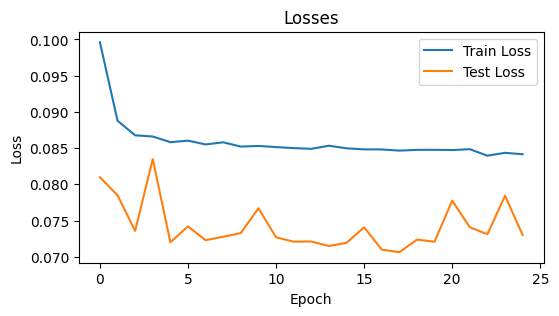

In [79]:
model, train_losses, test_losses = model_fit(
    model, loss_function, optimizer, train_loader, test_loader, num_epochs=25, checkpoint=5, patience=10)
plot_losses(train_losses, test_losses)

In [40]:
from datetime import datetime, timedelta

# Initialize an empty DataFrame
submission_df = pd.DataFrame(
    columns=['submission_ID', 'city_id', 'date', "avg_temp_c"])
# Initialize an non-empty DataFrame
submission_df = pd.DataFrame(
    {'submission_ID': [0], 'city_id': ['C000'], 'date': [datetime.strptime('2019-01-01', '%Y-%m-%d')], "avg_temp_c": [0.0]})

# Initialize the submission ID
submission_ID = 1
date = datetime.strptime('2019-01-01', '%Y-%m-%d')
# Iterate over the list of sequences
for i, (inputs,) in enumerate(predict_loader):
    # Generate the city_id
    city_id = 'C' + str(i+1).zfill(3)

    # Use the model to predict the next 14 days
    predictions = model(inputs)
    predictions = predictions.detach().cpu().numpy().flatten()
    # For each day in the prediction
    for j in range(7):
        # Append a new row to the DataFrame
        new_entry = pd.DataFrame(
            {'submission_ID': [submission_ID], 'city_id': [city_id], 'date': [date], "avg_temp_c": [predictions[j]]}, index=[0])
        submission_df = pd.concat([submission_df, new_entry], ignore_index=True)
        # Increment the submission ID
        date += timedelta(days=1)
        submission_ID += 1
    date = datetime.strptime('2019-01-01', '%Y-%m-%d')
# Drop the initial row
submission_df = submission_df.iloc[1:]

In [26]:
print(submission_df)

    submission_ID city_id       date  avg_temp_c
1               1    C001 2019-01-01   -0.611052
2               2    C001 2019-01-02   -0.662991
3               3    C001 2019-01-03   -0.687810
4               4    C001 2019-01-04   -0.696068
5               5    C001 2019-01-05   -0.702161
6               6    C001 2019-01-06   -0.716913
7               7    C001 2019-01-07   -0.665962
8               8    C002 2019-01-01   -0.420817
9               9    C002 2019-01-02   -0.394993
10             10    C002 2019-01-03   -0.375197
11             11    C002 2019-01-04   -0.357673
12             12    C002 2019-01-05   -0.370459
13             13    C002 2019-01-06   -0.403783
14             14    C002 2019-01-07   -0.439442


In [18]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
# from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

# Load dataset
# X, y = load_boston(return_X_y=True)

# Split dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models
base_models = [
    ('lr', LinearRegression()),
    ('svr', SVR()),
    ('dt', DecisionTreeRegressor())
]

In [20]:
# Define the Stacking Regressor
model = StackingRegressor(estimators=base_models, final_estimator=LinearRegression())

# Convert PyTorch tensors to NumPy arrays for sklearn
# Note: This step assumes X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor are already defined as in your snippet
X_train_np = X_train_tensor.cpu().detach().numpy()
y_train_np = y_train_tensor.cpu().detach().numpy()
X_test_np = X_test_tensor.cpu().detach().numpy()
y_test_np = y_test_tensor.cpu().detach().numpy()

In [21]:
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
y_train_flattened = y_train.reshape(X_train.shape[0], -1)

In [24]:
# Fit the Stacking Regressor
model.fit(X_train_flattened, y_train_flattened)

# Make predictions
# predictions = model.predict(X_test_np)

ValueError: y should be a 1d array, got an array of shape (142990, 7) instead.

In [83]:
# Initialize and train the Stacking model
model = StackingRegressor(estimators=base_models, final_estimator=LinearRegression())
model.fit(X_train.flatten(), y_train.flatten())

# Make predictions
predictions = model.predict(X_test)

ValueError: Expected 2D array, got 1D array instead:
array=[-1.24465196 -1.61516423 -1.18124567 ...  1.64904362  1.58756233
  1.43095812].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.